In [49]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

# Load the new dataset
df = pd.read_csv('D600 Task 2 Dataset 1 Housing Information.csv')

# Drop the ID column and price columns, id is for datat storage and price is over powering all other variable and causing multicollinearity issues.
df = df.drop(columns=['ID','Price'])

# Preview the data
print("Data Shape:", df.shape)
df.head()

Data Shape: (7000, 20)


,SquareFootage,NumBathrooms,NumBedrooms,BackyardSpace,CrimeRate,SchoolRating,AgeOfHome,DistanceToCityCenter,EmploymentRate,PropertyTaxRate,RenovationQuality,LocalAmenities,TransportAccess,Fireplace,HouseColor,Garage,Floors,Windows,PreviousSalePrice,IsLuxury
0,566.62,1.00,4,779.42,20.56,5.62,39.46,10.08,97.29,1.84,4.93,4.44,4.55,Yes,Blue,No,1,13,181861.54,0
1,1472.34,1.00,2,656.13,15.62,5.63,40.51,7.89,93.22,0.95,4.08,5.56,6.83,No,Green,No,1,17,50042.60,0
2,550.00,1.78,3,754.57,12.47,9.20,48.38,23.74,96.60,1.87,4.26,8.07,8.48,Yes,Green,Yes,2,34,48400.34,0
3,941.81,2.04,2,439.59,22.22,7.08,94.67,5.22,91.45,1.45,4.45,5.00,6.27,Yes,Red,No,1,14,84594.12,0
4,550.00,1.06,3,353.03,8.28,5.93,16.80,43.13,86.50,1.26,3.36,5.46,6.99,No,White,Yes,1,21,22934.60,0


In [50]:
# 1. Binary Encoding (Yes=1, No=0)
binary_cols = ['Fireplace', 'Garage']
for col in binary_cols:
    # Maps if the column still contains 'Yes'/'No' strings (dtype 'object')
    if df[col].dtype == 'object' and df[col].astype(str).str.strip().isin(['Yes', 'No']).any():
        df[col] = df[col].astype(str).str.strip().map({'Yes': 1, 'No': 0})
    # Convert to category type to ensure describe shows categorical stats.
    df[col] = df[col].astype('category')

# Convert to category type to ensure describe() shows categorical stats.
df['IsLuxury'] = df['IsLuxury'].astype('category')

# 2. One-Hot Encoding for HouseColor
if 'HouseColor' in df.columns:
    df = pd.get_dummies(df, columns=['HouseColor'], drop_first=True)

# 3. Remove rows with negative values.
initial_rows = df.shape[0]
df = df[df['PreviousSalePrice'] >= 0]
df = df[df['Windows'] >= 0]
removed_rows = initial_rows - df.shape[0]
print(f"Removed {removed_rows} rows with negative 'PreviousSalePrice' or 'Windows'.")

# 4. Check for Nulls.
print("\nNull Values:\n", df.isnull().sum())

# Show cleaned dataframe info
print("\nCleaned Data Info:")
df.info()

Removed 78 rows with negative 'PreviousSalePrice' or 'Windows'.

Null Values:
 SquareFootage           0
NumBathrooms            0
NumBedrooms             0
BackyardSpace           0
CrimeRate               0
SchoolRating            0
AgeOfHome               0
DistanceToCityCenter    0
EmploymentRate          0
PropertyTaxRate         0
RenovationQuality       0
LocalAmenities          0
TransportAccess         0
Fireplace               0
Garage                  0
Floors                  0
Windows                 0
PreviousSalePrice       0
IsLuxury                0
HouseColor_Green        0
HouseColor_Red          0
HouseColor_White        0
HouseColor_Yellow       0
dtype: int64

Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 6922 entries, 0 to 6999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   SquareFootage         6922 non-null   float64 
 1   NumBathrooms          6922 

In [51]:
# Display floats with 2 decimal places.
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# Increase max columns to ensure all features are displayed
#pd.set_option('display.max_columns', None)

print("Descriptive Statistics for IsLuxury:\n")
display(df['IsLuxury'].describe())

initial_independent_features = df.drop(columns=['IsLuxury']).columns.tolist()

# Separate features into categorical and continuous lists.
categorical_independent_features = []
continuous_independent_features = []

for feature in initial_independent_features:
    if df[feature].dtype == 'category' or df[feature].dtype == 'bool':
        categorical_independent_features.append(feature)
    else:
        continuous_independent_features.append(feature)

# Display Descriptive Statistics for Continuous Variables.
print("\nDescriptive Statistics for Continuous Independent Variables:\n")
continuous_stats_list = []
for feature in continuous_independent_features:
    continuous_stats_list.append(df[feature].describe().rename(feature))
continuous_stats_df = pd.concat(continuous_stats_list, axis=1).T
display(continuous_stats_df)

# Display Descriptive Statistics for Categorical Variables.
print("\nDescriptive Statistics for Categorical Independent Variables:\n")
categorical_stats_list = []
for feature in categorical_independent_features:
    categorical_stats_list.append(df[feature].describe().rename(feature))
categorical_stats_df = pd.concat(categorical_stats_list, axis=1).T
display(categorical_stats_df)

Descriptive Statistics for IsLuxury:



count     6922
unique       2
top          1
freq      3501
Name: IsLuxury, dtype: int64


Descriptive Statistics for Continuous Independent Variables:



,count,mean,std,min,25%,50%,75%,max
SquareFootage,6922.00,1050.99,425.84,550.00,663.71,1001.09,1344.42,2874.70
NumBathrooms,6922.00,2.13,0.95,1.00,1.29,2.00,2.77,5.81
NumBedrooms,6922.00,3.01,1.02,1.00,2.00,3.00,4.00,7.00
BackyardSpace,6922.00,511.23,280.00,0.39,300.71,495.81,703.90,1631.36
CrimeRate,6922.00,31.22,18.03,0.03,17.41,30.34,43.64,99.73
SchoolRating,6922.00,6.95,1.89,0.22,5.66,7.01,8.36,10.00
AgeOfHome,6922.00,46.86,31.82,0.01,20.77,42.69,67.31,178.68
DistanceToCityCenter,6922.00,17.44,11.99,0.00,7.81,15.60,25.17,65.20
EmploymentRate,6922.00,93.71,4.51,72.05,90.62,94.01,97.41,99.90
PropertyTaxRate,6922.00,1.50,0.50,0.01,1.16,1.49,1.84,3.36



Descriptive Statistics for Categorical Independent Variables:



,count,unique,top,freq
Fireplace,6922,2,0,5111
Garage,6922,2,0,4436
HouseColor_Green,6922,2,False,5566
HouseColor_Red,6922,2,False,5592
HouseColor_White,6922,2,False,5490
HouseColor_Yellow,6922,2,False,5513


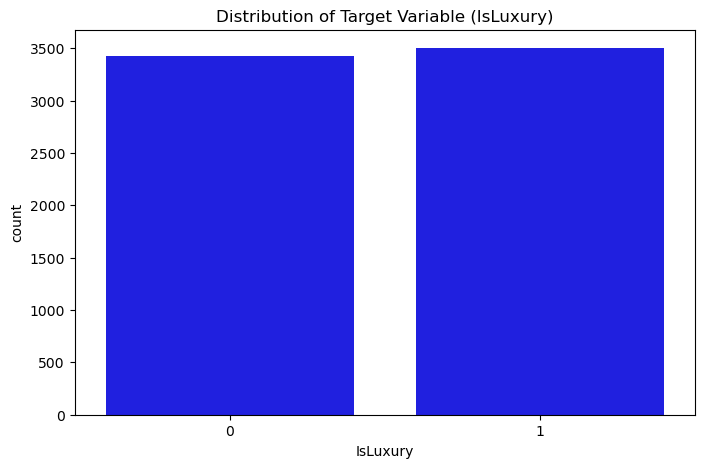

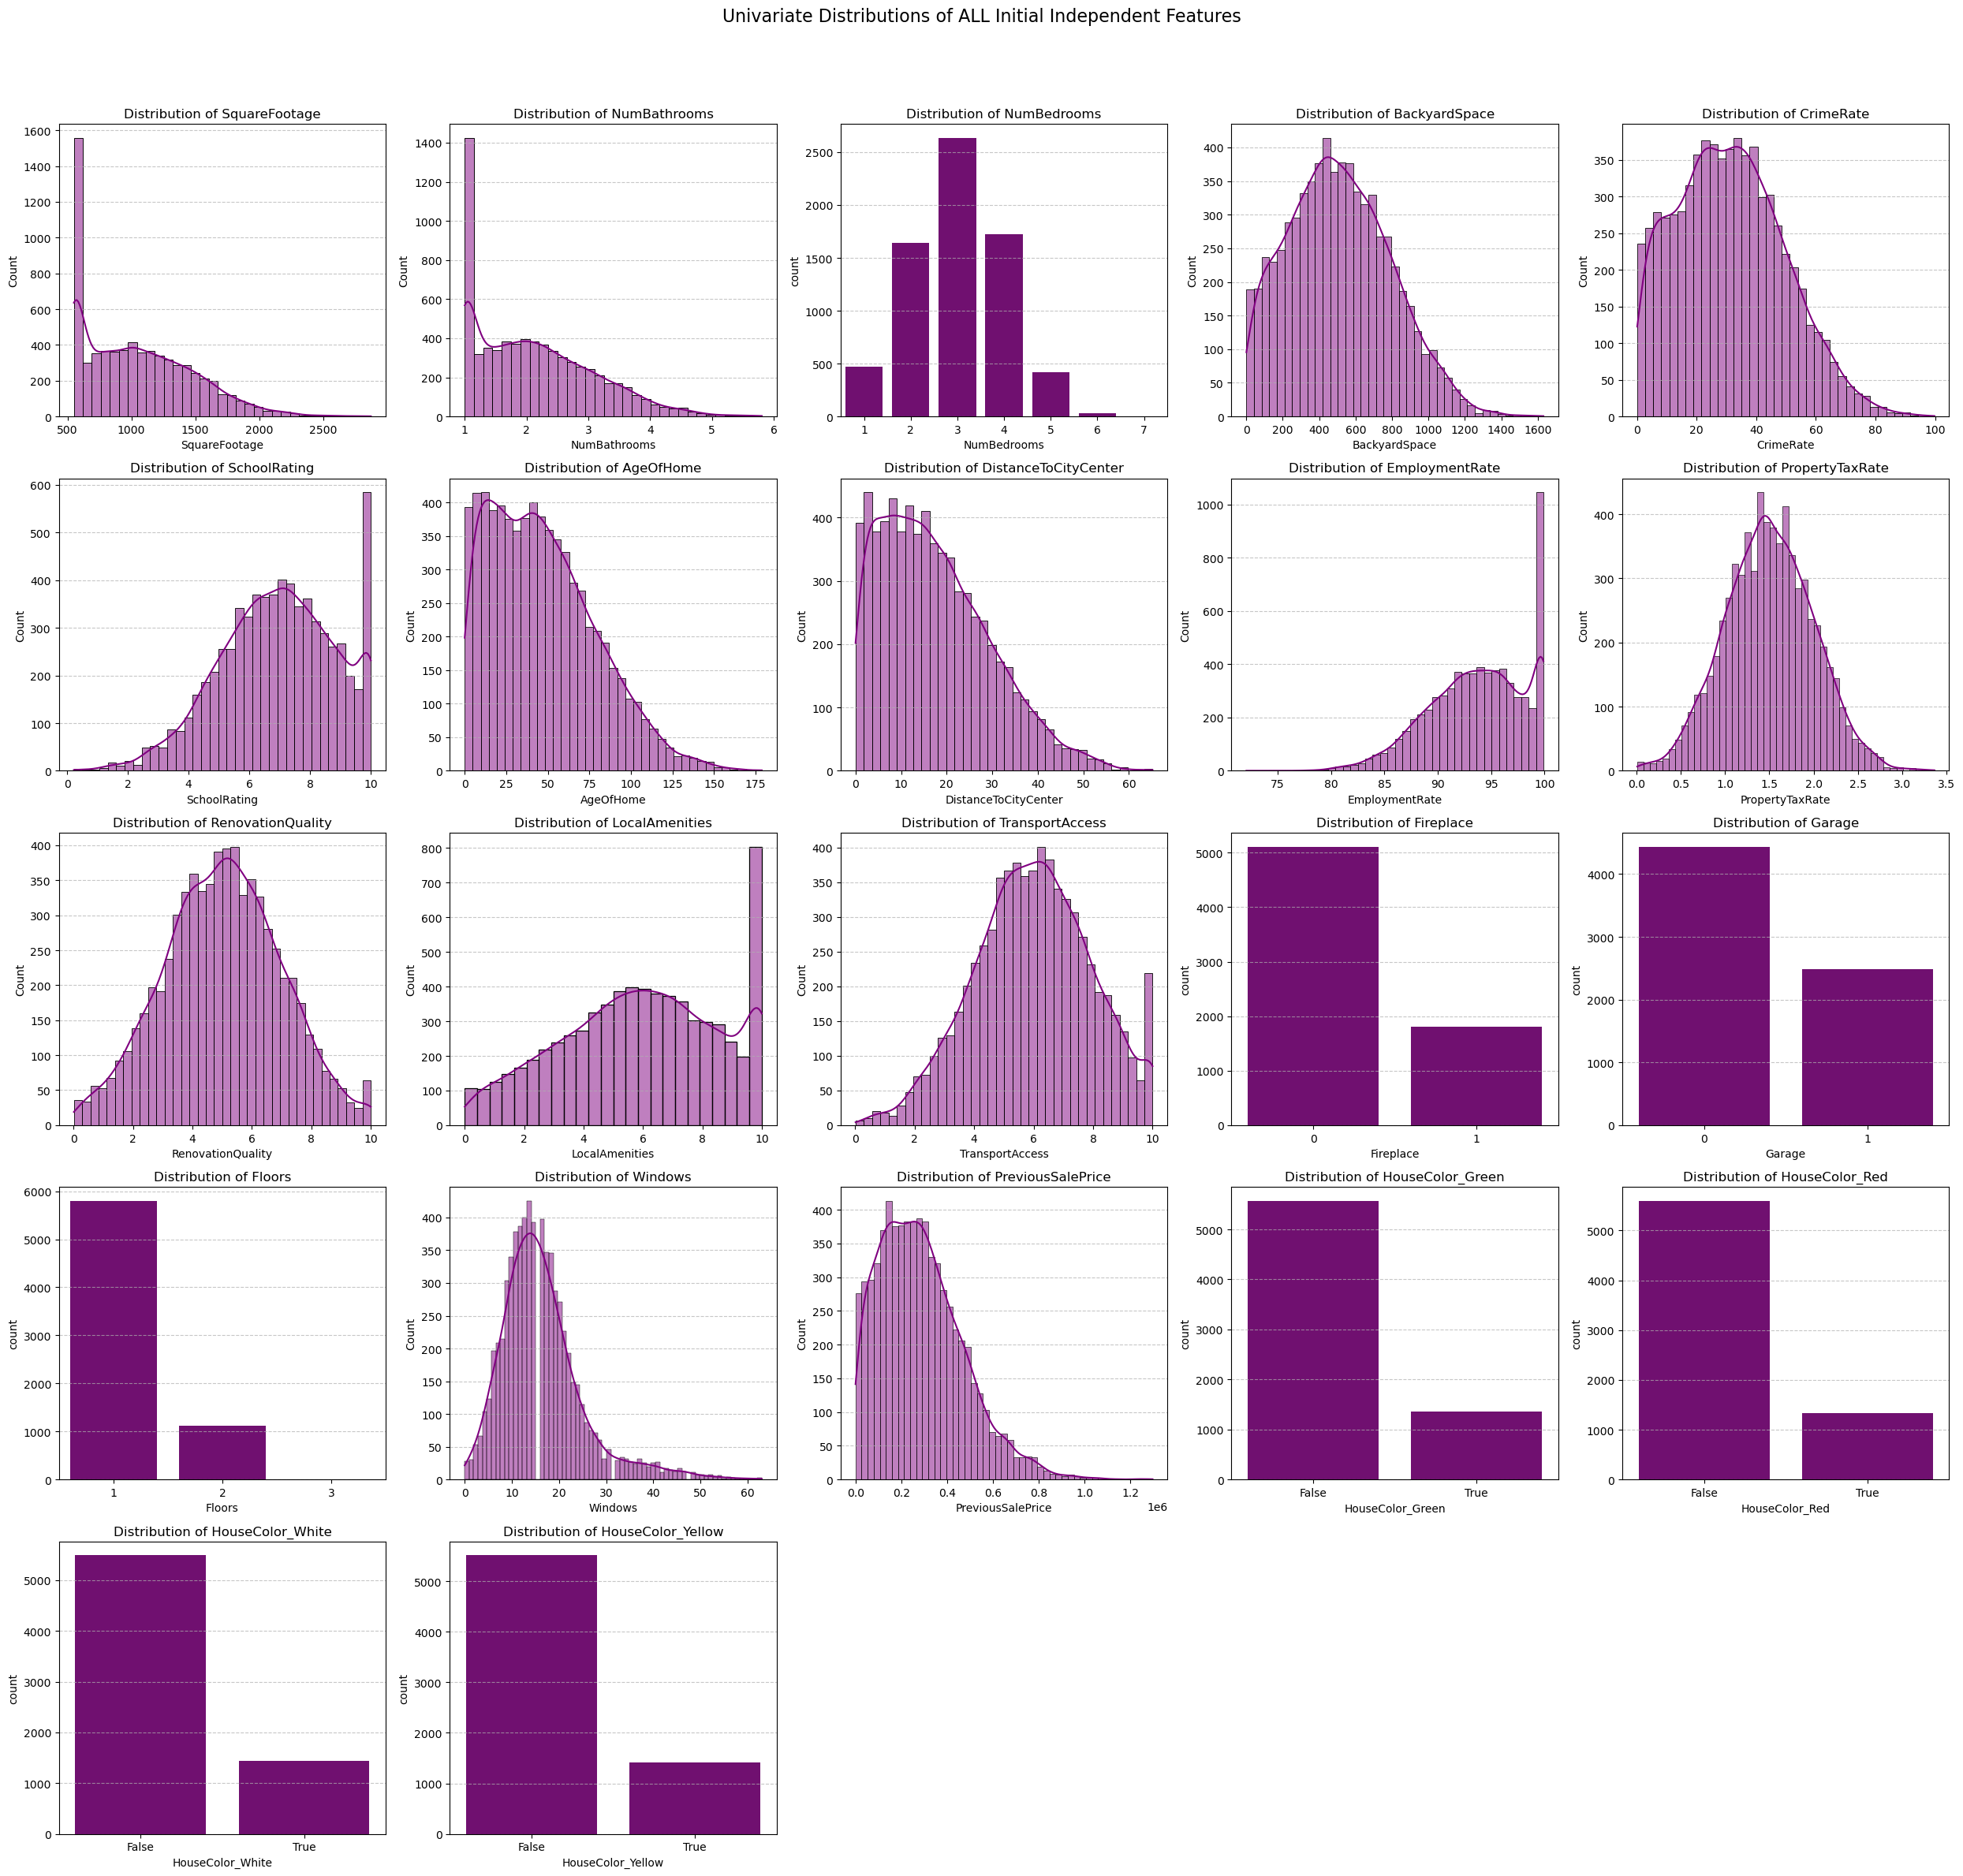

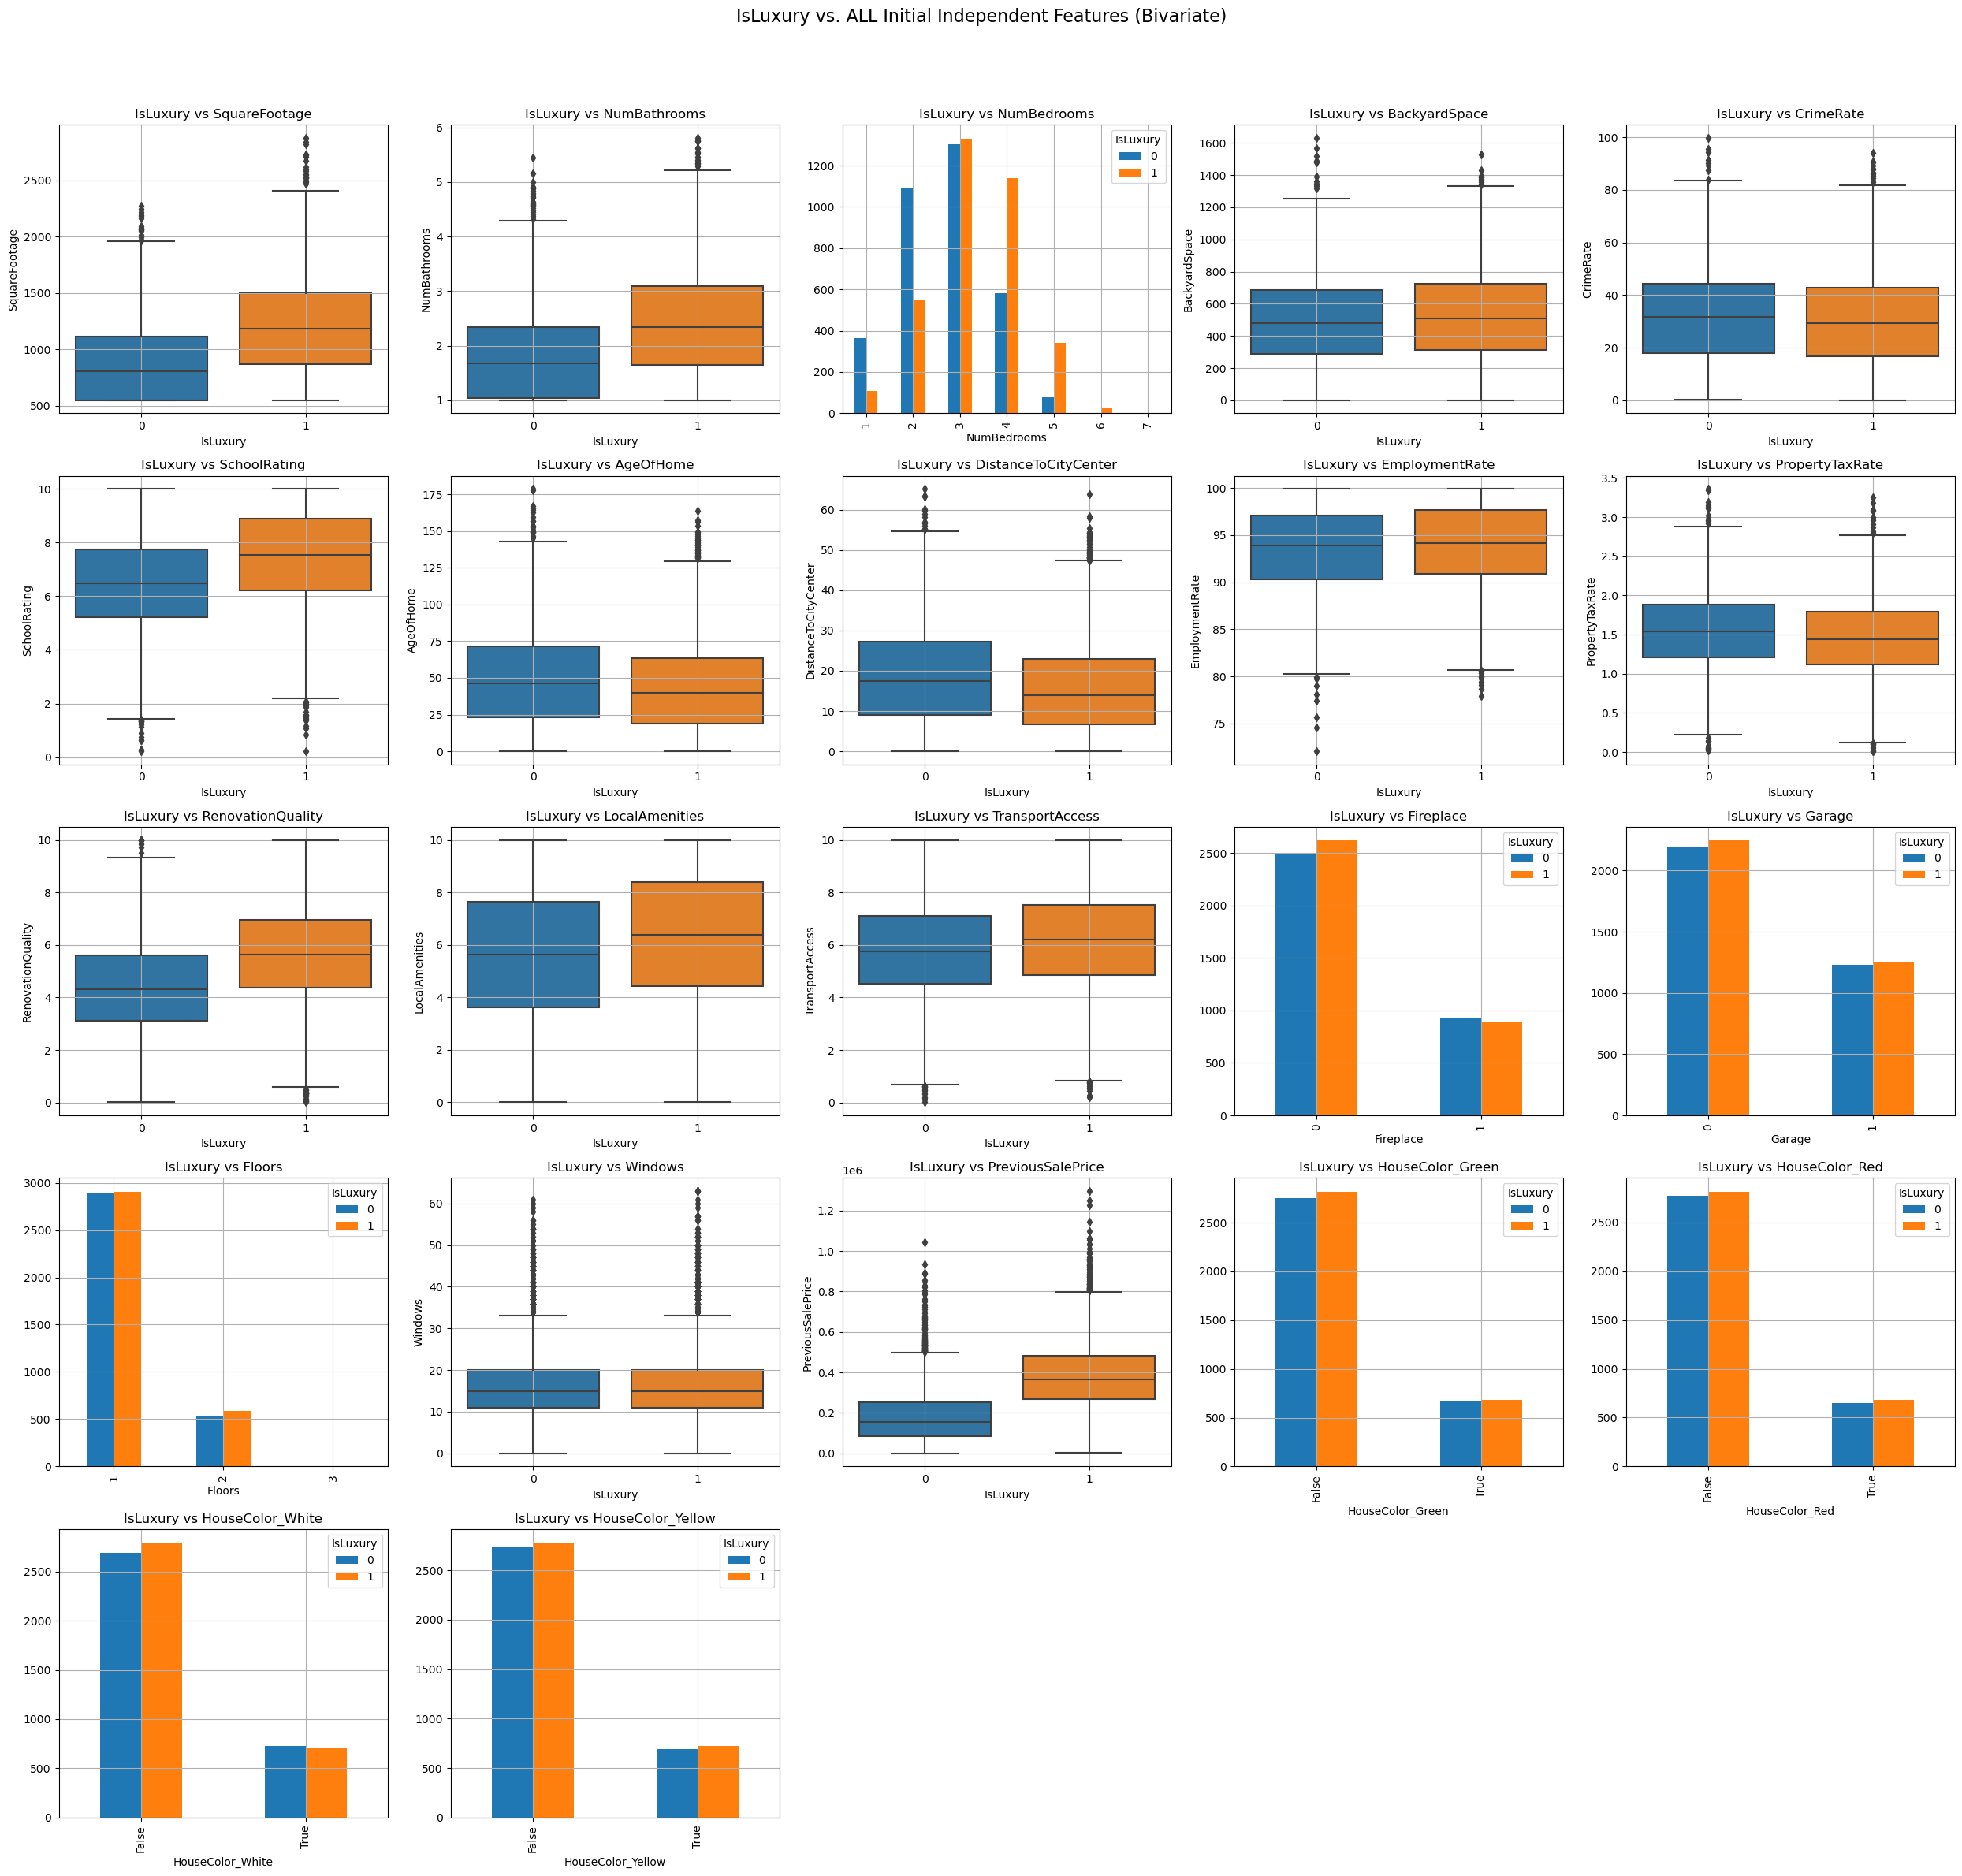

In [65]:
# Define all Initial Independent Variables for Visualization.
initial_independent_features = df.drop(columns=['IsLuxury']).columns.tolist()

# 1. Univariate Visualization for IsLuxury.
plt.figure(figsize=(8, 5))
sns.countplot(x=df['IsLuxury'], color='blue')
plt.title('Distribution of Target Variable (IsLuxury)')
plt.show()

# 2. Univariate Visualizations of all Initial Independent Variables.
plt.figure(figsize=(25, 25)) # Adjust figure size for more plots
plt.suptitle('Univariate Distributions of ALL Initial Independent Features', fontsize=16)

# Group continuous and categorical features for.
continuous_features = [f for f in initial_independent_features if df[f].dtype in ['float64', 'int64'] and len(df[f].unique()) > 10]
categorical_features = [f for f in initial_independent_features if f not in continuous_features]

for i, col in enumerate(initial_independent_features):
    plt.subplot(5, 5, i+1)
    if col in continuous_features:
        sns.histplot(df[col], kde=True, color='purple')
    else:
        sns.countplot(x=df[col], color='purple')
    plt.title(f'Distribution of {col}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 3. Bivariate Visualizations.
plt.figure(figsize=(25, 25))
plt.suptitle('IsLuxury vs. ALL Initial Independent Features (Bivariate)', fontsize=16)

for i, col in enumerate(initial_independent_features):
    plt.subplot(5, 5, i+1)
    if col in continuous_features:
        # Box plot: Continuous variable vs Categorical IsLuxury
        sns.boxplot(x=df['IsLuxury'], y=df[col])
    else:
        # Bar chart: Categorical variable vs Categorical IsLuxury
        pd.crosstab(df[col], df['IsLuxury']).plot(kind='bar', ax=plt.gca())
        plt.legend(title='IsLuxury')
    plt.title(f'IsLuxury vs {col}')
    plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [66]:
# Define Features (X) and Target (y)
target = 'IsLuxury'

# X should drop only the 'IsLuxury' column, retaining all independent features
X = df.drop(columns=[target])
y = df[target]

# Split the data: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine X and y back together and save to CSV for export.
train_export = X_train.copy()
train_export[target] = y_train
train_export.to_csv('train_data_task_2.csv', index=False)

test_export = X_test.copy()
test_export[target] = y_test
test_export.to_csv('test_data_task_2.csv', index=False)


print(f"Training Set Shape: {X_train.shape}")
print(f"Test Set Shape: {X_test.shape}")

Training Set Shape: (5537, 22)
Test Set Shape: (1385, 22)


In [67]:
from sklearn.preprocessing import StandardScaler
import numpy as np # Ensure numpy is imported

# Identify numerical features for scaling
features_to_scale = X_train.select_dtypes(include=np.number).columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data.
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

print("Scaled Training Data Sample:")
display(X_train_scaled[features_to_scale].head())

Scaled Training Data Sample:


,SquareFootage,NumBathrooms,NumBedrooms,BackyardSpace,CrimeRate,SchoolRating,AgeOfHome,DistanceToCityCenter,EmploymentRate,PropertyTaxRate,RenovationQuality,LocalAmenities,TransportAccess,Floors,Windows,PreviousSalePrice
3595,0.27,0.58,-0.03,-0.76,-1.50,1.13,0.80,3.40,1.13,0.86,0.83,-1.25,-1.52,-0.44,-1.29,0.69
6772,-0.06,-1.01,0.95,-1.62,-1.00,0.71,-0.99,-1.20,0.07,0.05,0.61,0.73,-0.22,-0.44,-0.16,0.34
27,-1.16,-1.11,-0.03,-1.11,0.02,-0.21,1.06,-0.77,-1.92,-0.33,-0.37,0.42,-0.58,-0.44,-0.84,-1.30
6221,1.70,-0.92,-0.03,0.17,0.76,0.68,0.56,-1.36,-0.18,-0.66,-0.48,-1.45,-0.64,-0.44,-0.27,0.41
65,-0.18,-1.03,-0.03,-1.17,2.27,0.18,-0.27,1.55,0.17,0.01,-0.33,-0.99,0.74,-0.44,0.52,-0.51


In [68]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression

# Initialize Linear Regression for SFS.
lr = LogisticRegression()

# Forward Stepwise Selection.
sfs = SFS(lr,
          k_features=5, 
          forward=True,
          floating=True,
          scoring='neg_mean_squared_error',
          cv=5) 

# Fit SFS using the SCALED training data
sfs = sfs.fit(X_train_scaled, y_train)

# Get the selected feature names
selected_features = list(sfs.k_feature_names_)
print("Selected Features for Reduced Model:", selected_features)

Selected Features for Reduced Model: ['NumBathrooms', 'NumBedrooms', 'RenovationQuality', 'Floors', 'PreviousSalePrice']


In [70]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import statsmodels.api as sm



# Filter X_train and X_test to only include selected features
X_train_reduced = X_train_scaled[selected_features]
X_test_reduced = X_test_scaled[selected_features]

# Add Constant for Statsmodels
X_train_reduced_const = sm.add_constant(X_train_reduced)
X_test_reduced_const = sm.add_constant(X_test_reduced)

# Fit the Logit Model
logit_model = sm.Logit(y_train.astype(int), X_train_reduced_const).fit()

# Print Summary
print(logit_model.summary())

# Predictions
y_train_pred = (logit_model.predict(X_train_reduced_const) > 0.50).astype(int)
y_test_pred = (logit_model.predict(X_test_reduced_const) > 0.50).astype(int)

# Accuracy Scores
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"AIC: {logit_model.aic}")
print(f"BIC: {logit_model.bic}")

print(f"\nTraining Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy:     {accuracy_test:.4f}")

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))

Optimization terminated successfully.
         Current function value: 0.498087
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               IsLuxury   No. Observations:                 5537
Model:                          Logit   Df Residuals:                     5531
Method:                           MLE   Df Model:                            5
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                  0.2813
Time:                        20:54:13   Log-Likelihood:                -2757.9
converged:                       True   LL-Null:                       -3837.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1651      0.034      4.875      0.000       0.099       0.232
NumBathr

In [73]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import statsmodels.api as sm

# Remove 'Floors' from selected features.
selected_features = [f for f in selected_features if f != 'Floors']

# Filter X_train and X_test to only include selected features
X_train_reduced = X_train_scaled[selected_features]
X_test_reduced = X_test_scaled[selected_features]

# Add Constant for Statsmodels
X_train_reduced_const = sm.add_constant(X_train_reduced)
X_test_reduced_const = sm.add_constant(X_test_reduced)

# Fit the Logit Model
logit_model = sm.Logit(y_train.astype(int), X_train_reduced_const).fit()

# Print Summary
print(logit_model.summary())

# Predictions
y_train_pred = (logit_model.predict(X_train_reduced_const) > 0.50).astype(int)
y_test_pred = (logit_model.predict(X_test_reduced_const) > 0.50).astype(int)

# Accuracy Scores
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"AIC: {logit_model.aic}")
print(f"BIC: {logit_model.bic}")

print(f"\nTraining Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy:     {accuracy_test:.4f}")

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
print("\nConfusion Matrix (Train Set):")
print(confusion_matrix(y_train, y_train_pred))
print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))

Optimization terminated successfully.
         Current function value: 0.498294
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               IsLuxury   No. Observations:                 5537
Model:                          Logit   Df Residuals:                     5532
Method:                           MLE   Df Model:                            4
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                  0.2810
Time:                        21:12:19   Log-Likelihood:                -2759.1
converged:                       True   LL-Null:                       -3837.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1655      0.034      4.886      0.000       0.099       0.232
NumBathr

In [58]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Use only the selected features (without constant) for VIF calculation
X_for_vif = X_train_scaled[selected_features]

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["feature"] = X_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_for_vif.values, i) for i in range(X_for_vif.shape[1])]

print("Variance Inflation Factor (VIF) for Selected Features:")
print(vif_data.sort_values('VIF', ascending=False))

Variance Inflation Factor (VIF) for Selected Features:
             feature  VIF
3  PreviousSalePrice 2.07
0       NumBathrooms 1.40
1        NumBedrooms 1.39
2  RenovationQuality 1.38
